## Environment Setup

#### Install Libraries

In [ ]:
# install UMAP
!pip install umap-learn

# install HDBSCAN
!pip install hdbscan

#### Import Libraries

In [41]:
# Basic Operations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# UMAP & HDBSCAN
import umap
import hdbscan
# optimization
import itertools
# evaluation methods
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Agglomerative Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from matplotlib.backends.backend_pdf import PdfPages

# K-Means
from sklearn.cluster import KMeans



#### Import and Extract Dataset

In [57]:
data = pd.read_csv('https://raw.githubusercontent.com/annikazwei/VI-Structure-with-NLP/refs/heads/main/Data_Output/NLP_Vectors_BI.csv')
data = data.rename(columns={"Unnamed: 0": "Interests"})
interests = data['Interests']
embeddings = data.iloc[:, 1:].values
vectors = data.iloc[:, 1:]
labels = data.iloc[:, 0].tolist()

## HDBSCAN Clustering With UMAP Reduction

#### Optimization Function

The optimization function is used to find optimal values for UMAP and HDBSCAN parameters. 

In [3]:
# Function to Evaluate Clustering
def evaluate_clustering(embeddings, umap_params, hdbscan_params):
    reducer = umap.UMAP(**umap_params).fit(embeddings)
    reduced_embeddings = reducer.transform(embeddings)
    
    clusterer = hdbscan.HDBSCAN(**hdbscan_params).fit(reduced_embeddings)
    labels = clusterer.labels_
    noise_points = list(labels).count(-1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Calculate evaluation metrics
    silhouette = silhouette_score(reduced_embeddings, labels) if n_clusters > 1 else None
    ch_score = calinski_harabasz_score(reduced_embeddings, labels) if n_clusters > 1 else None
    db_score = davies_bouldin_score(reduced_embeddings, labels) if n_clusters > 1 else None
    
    # Calculate cluster size distribution metric (variance of cluster sizes)
    cluster_sizes = [list(labels).count(i) for i in set(labels) if i != -1]

    return {
        "noise_points": noise_points,
        "n_clusters": n_clusters,
        "silhouette": silhouette,
        "calinski_harabasz": ch_score,
        "davies_bouldin": db_score,
    }

In [4]:
# Function for Parameter Search
def parameter_search(embeddings, umap_grid, hdbscan_grid):
    best_config_overall = None
    best_results_overall = None

    best_by_metric = {
        "silhouette": {"config": None, "results": None},
        "calinski_harabasz": {"config": None, "results": None},
        "davies_bouldin": {"config": None, "results": None},
        "noise_points": {"config": None, "results": None},
    }

    # Generate all combinations of UMAP and HDBSCAN parameters
    umap_combinations = list(itertools.product(
        umap_grid["n_components"],
        umap_grid["n_neighbors"],
        umap_grid["min_dist"]
    ))
    hdbscan_combinations = list(itertools.product(
        hdbscan_grid["min_cluster_size"],
        hdbscan_grid["min_samples"],
        ['eom', 'leaf']  # Add both cluster selection methods
    ))

    # Iterate through all combinations
    for umap_params in umap_combinations:
        for hdbscan_params in hdbscan_combinations:
            current_umap_params = {
                "n_components": umap_params[0],
                "n_neighbors": umap_params[1],
                "min_dist": umap_params[2],
                "random_state": 42,
            }
            current_hdbscan_params = {
                "min_cluster_size": hdbscan_params[0],
                "min_samples": hdbscan_params[1],
                "cluster_selection_method": hdbscan_params[2]
            }
            print(f"Testing UMAP params: {current_umap_params}, HDBSCAN params: {current_hdbscan_params}")

            # Evaluate clustering
            results = evaluate_clustering(embeddings, current_umap_params, current_hdbscan_params)

            # Track best configurations for individual metrics
            for metric, criteria in best_by_metric.items():
                if metric == "davies_bouldin":
                    if results[metric] is not None and (criteria["results"] is None or results[metric] < criteria["results"][metric]):
                        best_by_metric[metric] = {"config": (current_umap_params, current_hdbscan_params), "results": results}
                elif metric == "noise_points":
                    if results[metric] is not None and (criteria["results"] is None or results[metric] < criteria["results"][metric]):
                        best_by_metric[metric] = {"config": (current_umap_params, current_hdbscan_params), "results": results}
                else:  # For silhouette and calinski_harabasz (maximize)
                    if results[metric] is not None and (criteria["results"] is None or results[metric] > criteria["results"][metric]):
                        best_by_metric[metric] = {"config": (current_umap_params, current_hdbscan_params), "results": results}

            # Determine overall best configuration
            if best_results_overall is None or (
                results["silhouette"] is not None and
                (
                    results["silhouette"] > (best_results_overall["silhouette"] or 0) or
                    results["calinski_harabasz"] > (best_results_overall["calinski_harabasz"] or 0) or
                    results["davies_bouldin"] < (best_results_overall["davies_bouldin"] or float('inf'))
                )
            ):
                best_config_overall = (current_umap_params, current_hdbscan_params)
                best_results_overall = results

    return best_config_overall, best_results_overall, best_by_metric

In [5]:
# Define Grids for UMAP and HDBSCAN
umap_grid = {
    "n_components": [15, 20, 25], 
    "n_neighbors": [2, 3, 5], 
    "min_dist": [0.01, 0.05, 0.1],
}

hdbscan_grid = {
    "min_cluster_size": [2, 3, 4], 
    "min_samples": [1, 2, 3]
}

In [ ]:
# Run Parameter Search
best_config_overall, best_results_overall, best_by_metric = parameter_search(embeddings, umap_grid, hdbscan_grid)

# Output the best configuration and results
print("\nBest Overall Configuration:")
print("UMAP Parameters:", best_config_overall[0])
print("HDBSCAN Parameters:", best_config_overall[1])
print("Results:", best_results_overall)

print("\nBest Configurations by Metric:")
for metric, details in best_by_metric.items():
    print(f"\n{metric.capitalize()}:")
    print("  UMAP Parameters:", details["config"][0])
    print("  HDBSCAN Parameters:", details["config"][1])
    print("  Results:", details["results"])

#### Function for UMAP Dimension Reduction

In [7]:
def reduce_dimensions(embeddings):
    reducer = umap.UMAP(
        n_components = 25, 
        n_neighbors = 2, 
        min_dist = 0.01, 
        random_state = 42,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

#### Function for HDBSCAN Clustering

In [8]:
def perform_clustering(embeddings):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size = 2, 
        min_samples = 2, 
        allow_single_cluster = True,
        cluster_selection_method = 'eom',
    ).fit(embeddings)
    return clusterer

#### Dimension Reduction & Clustering

In [9]:
reduced_embeddings = reduce_dimensions(embeddings)
clusterer = perform_clustering(reduced_embeddings)

/Users/annikawei/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/annikawei/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/annikawei/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/annikawei/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Parameter Evaluation

In [10]:
# Calculate Evaluation Scores
labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
silhouette = silhouette_score(reduced_embeddings, labels) if n_clusters > 1 else None
calinski_harabasz = calinski_harabasz_score(reduced_embeddings, labels)
davies_bouldin = davies_bouldin_score(reduced_embeddings, labels)

In [11]:
# Print Evaluation Scores
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Score: {davies_bouldin}")

Number of clusters: 8
Number of noise points: 2
Silhouette Score: 0.8294634819030762
Calinski-Harabasz Score: 1618.648681640625
Davies-Bouldin Score: 0.24103453299463715


#### Dataframe for Results

In [12]:
hdbscan_output = pd.DataFrame(reduced_embeddings, columns=[f"UMAP_{i+1}" for i in range(reduced_embeddings.shape[1])])
hdbscan_output.insert(0, 'Interest', interests) 
hdbscan_output.insert(1, 'Cluster', clusterer.labels_)
hdbscan_output.insert(2, 'Cluster_Probability', clusterer.probabilities_)

hdbscan_output

,Interest,Cluster,Cluster_Probability,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,UMAP_6,UMAP_7,...,UMAP_16,UMAP_17,UMAP_18,UMAP_19,UMAP_20,UMAP_21,UMAP_22,UMAP_23,UMAP_24,UMAP_25
0,life science,6,1.000000,10.984294,5.299196,6.251344,5.184079,2.295752,5.225235,4.844056,...,6.311605,3.737576,4.113806,6.305713,4.519217,3.292734,3.871205,2.958922,2.135118,2.092906
1,medical science,6,1.000000,11.017192,5.218471,6.271049,5.210646,2.262370,5.213142,4.849294,...,6.400005,3.715340,4.157379,6.414320,4.600076,3.180313,3.838516,2.940100,2.140189,2.059076
2,health care service,3,1.000000,10.762259,5.121116,6.192292,4.904592,2.470652,5.179655,5.215617,...,6.416853,3.817570,4.090090,6.090676,4.737141,3.170732,3.844402,3.063529,2.036081,1.915243
3,media,0,1.000000,4.414730,7.828119,5.654346,6.803453,4.484700,5.718266,2.757999,...,6.739776,4.341225,5.753776,1.237189,6.290530,6.744328,6.309406,3.212255,4.219425,5.201580
4,applied arts and design,0,1.000000,4.392937,7.712500,5.715338,6.900097,4.274000,5.836255,2.794879,...,6.746998,4.305086,5.787941,1.256681,6.225467,5.969346,6.299294,3.274997,4.196745,5.274898
5,music,0,1.000000,4.535243,7.705097,5.699535,6.897958,4.147241,5.820273,2.889572,...,6.810085,4.368908,5.735102,1.347471,6.417342,5.926995,6.420116,3.135025,4.126384,5.261236
6,visual arts,0,1.000000,4.409270,7.665399,5.728226,6.921822,4.251095,5.829710,2.818198,...,6.834178,4.315996,5.776184,1.313457,6.297843,6.020500,6.374350,3.246887,4.157575,5.302672
7,performing arts,0,1.000000,4.470724,7.670470,5.732260,6.942646,4.157066,5.834614,2.920476,...,6.904308,4.350232,5.747534,1.417654,6.402036,6.043293,6.508552,3.171262,4.067503,5.307277
8,creative writing,0,1.000000,4.437359,7.763938,5.668536,6.843376,4.357711,5.758852,2.795884,...,6.806169,4.354958,5.744977,1.277128,6.320478,6.445686,6.356286,3.202248,4.190815,5.228120
9,culinary art,6,0.648797,11.016170,5.163006,6.265523,5.211328,2.247859,5.208032,4.869684,...,6.451028,3.730155,4.169146,6.444290,4.656437,3.106171,3.830346,2.955532,2.156576,2.056687


## Agglomerative Hierarchical Clustering

#### Function for Plotting Dendrogram

In [75]:
def plot_dendrogram(data, labels, title, orientation='right'):
    linked = linkage(data, method='ward')

    plt.figure(figsize=(10, 15))
    dendrogram(
        linked,
        labels=labels,
        leaf_rotation=0,
        leaf_font_size=10,
        orientation=orientation
    )

    # Formatting
    max_distance = max(linked[:, 2])
    for dist in range(5, int(max_distance), 5):
        plt.axvline(x=dist, color='gray', linestyle='--', lw=1)

    plt.title(f"{title}")
    plt.xlabel('Distance' if orientation in ['left', 'right'] else 'Categories')
    plt.ylabel('Categories' if orientation in ['left', 'right'] else 'Distance')
    
    plt.tight_layout()

#### Hierarchical Clustering Dendrogram

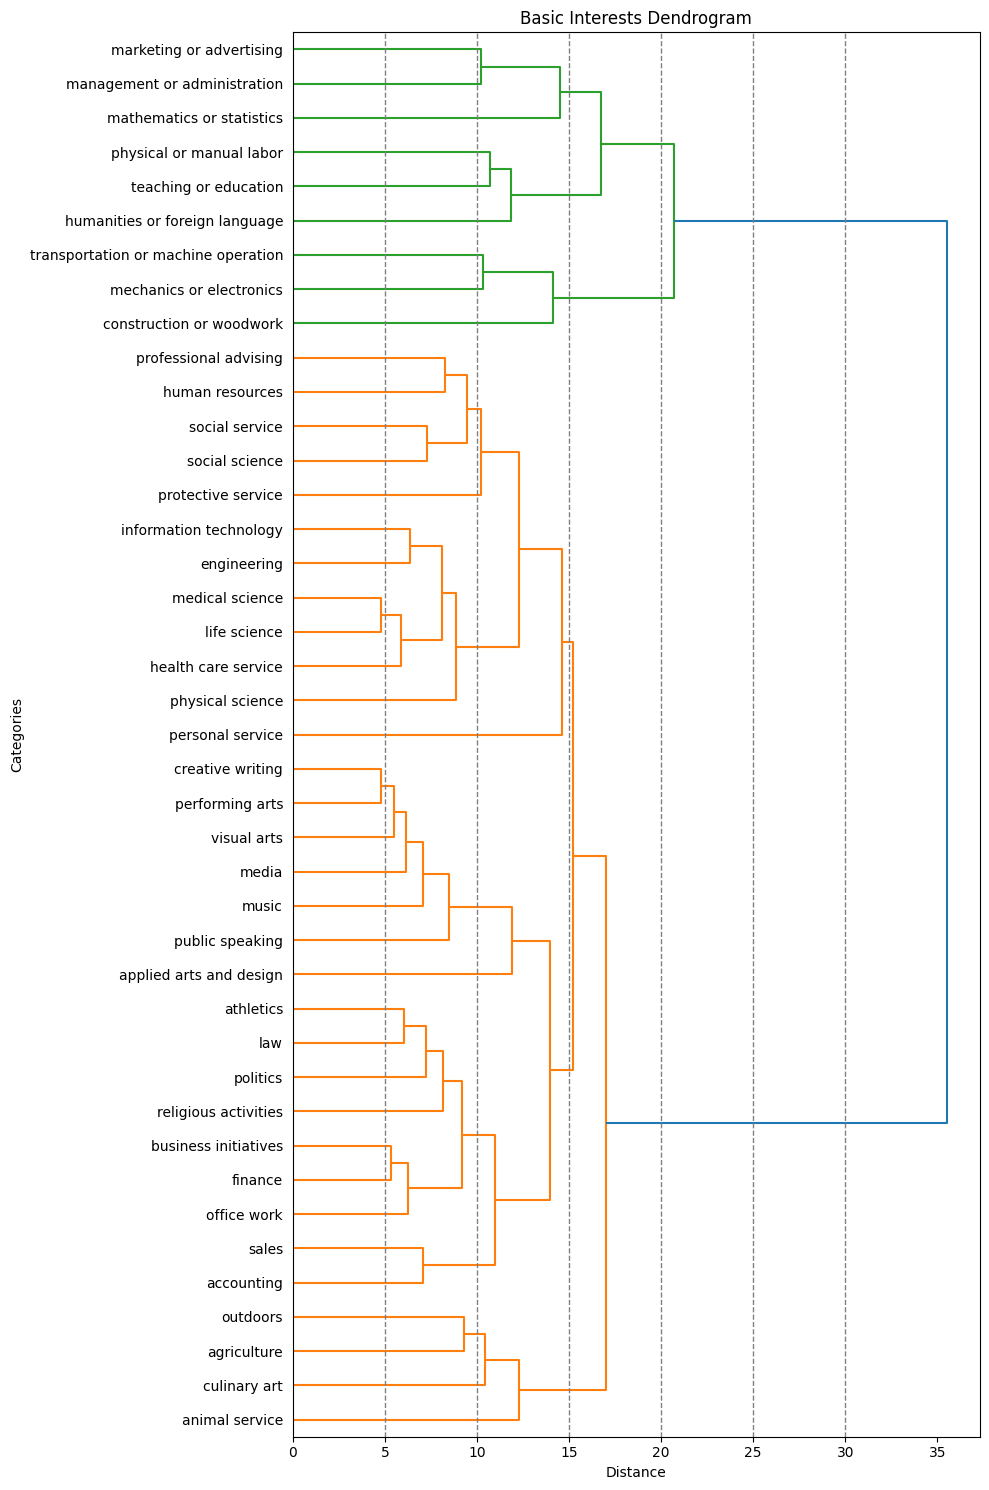

In [76]:
plot_dendrogram(
    vectors,
    labels,
    "Basic Interests Dendrogram",
    orientation='right'
)

## K-Means Clustering

#### The Elbow Method for Optimal Number of Clusters

In [44]:
# The Elbow Method
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 41) 

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors)
    
    # Inertia (sum of squared distances to closest cluster center)
    inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)


Optimal Number of Clusters

In [45]:
# Optimal Based on The Elbow Method
inertia_diff = np.diff(inertia)
second_derivative = np.diff(inertia_diff)
elbow_index = np.argmin(second_derivative) + 2
top_5_elbows = np.argsort(second_derivative)[:5] + 2

In [46]:
# Optimal Based on Silhouette Score
optimal_silhouette_clusters = np.argmax(silhouette_scores) + 2 
top_5_silhouettes = np.argsort(silhouette_scores)[-5:][::-1] + 2 

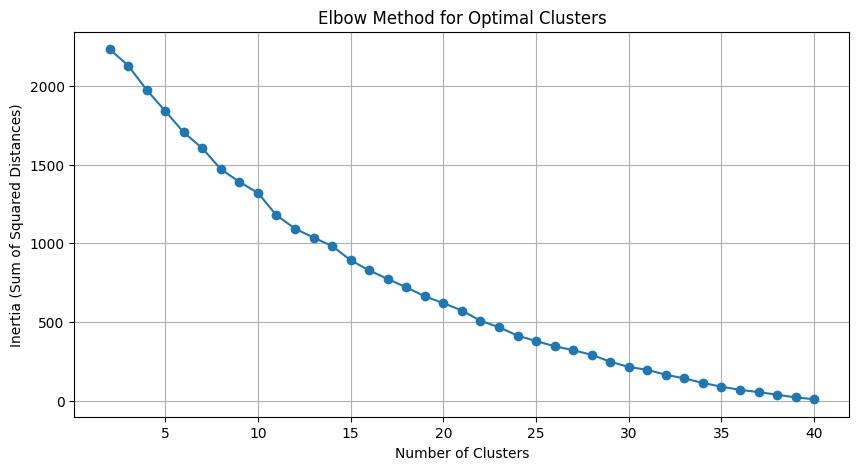

In [47]:
# Plot of The Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal Clusters')
plt.grid(True)
plt.show()

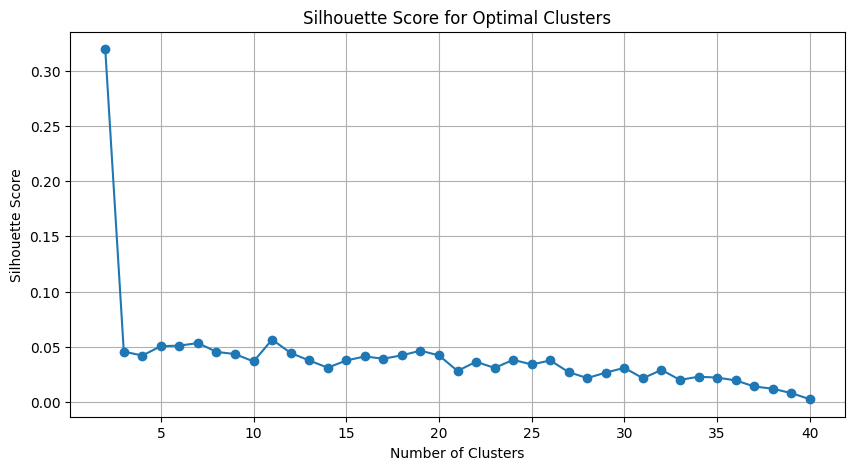

In [48]:
# Plot of Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.grid(True)
plt.show()

In [49]:
# Output
print(f'the optimal number of clusters based on the elbow method is {elbow_index}')
print(f'the optimal number of clusters based on the silhouette score is {optimal_silhouette_clusters}')
print(f'top 5 optimal clusters based on elbow method: {top_5_elbows}')
print(f'top 5 optimal clusters based on silhouette scores: {top_5_silhouettes}')

the optimal number of clusters based on the elbow method is 9
the optimal number of clusters based on the silhouette score is 2
top 5 optimal clusters based on elbow method: [ 9  2 13  6 20]
top 5 optimal clusters based on silhouette scores: [ 2 11  7  6  5]


#### K-Means with 9 Clusters

In [50]:

kmeans_9 = KMeans(n_clusters = 9, random_state = 42)
cluster_labels_9 = kmeans_9.fit_predict(vectors)

cluster_df = pd.DataFrame({
    'Basic Interests': data['Interests'], 
    '9 Cluster Labels': cluster_labels_9
})

#### K-Means with 11 Clusters

In [53]:
kmeans_11 = KMeans(n_clusters = 11, random_state = 42)
cluster_labels_11 = kmeans_11.fit_predict(vectors)

cluster_df['11 Cluster Labels'] = cluster_labels_11

#### Results

In [52]:
cluster_df

,Basic Interests,9 Cluster Labels,11 Cluster Labels
0,life science,3,3
1,medical science,3,3
2,health care service,3,3
3,media,6,6
4,applied arts and design,8,8
5,music,6,6
6,visual arts,6,6
7,performing arts,6,6
8,creative writing,6,6
9,culinary art,3,3
